## detect the fake profiles in online social networks using Neural Network

In [1]:
import sys
import csv
import os
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sexmachine.detector as gender
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from  sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import learning_curve
from sklearn.metrics import roc_curve, auc ,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline 
from pybrain.structure import SigmoidLayer
from pybrain.datasets import ClassificationDataSet
from pybrain.utilities import percentError
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.tools.xml.networkwriter import NetworkWriter
from pybrain.tools.xml.networkreader import NetworkReader

###### function for reading dataset from csv files

In [2]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y
    

###### function for predicting sex using name of person

In [3]:
def predict_sex(name):
    sex_predictor = gender.Detector(unknown_value=u"unknown",case_sensitive=False)
    first_name= name.str.split(' ').str.get(0)
    sex= first_name.apply(sex_predictor.get_gender)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex.map(sex_dict).astype(int)
    return sex_code

###### function for feature engineering

In [1]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

###### function for plotting confusion matrix

In [5]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###### function for plotting ROC curve

In [6]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print "False Positive rate: ",false_positive_rate
    print "True Positive rate: ",true_positive_rate


    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

###### Function for training data using Neural Network

In [7]:
def train(X,y):
    """ Trains and predicts dataset with a Neural Network classifier """

    ds = ClassificationDataSet( len(X.columns), 1,nb_classes=2)
    for k in xrange(len(X)): 
    	ds.addSample(X.iloc[k],np.array(y[k]))
    tstdata, trndata = ds.splitWithProportion( 0.20 )
    trndata._convertToOneOfMany( )
    tstdata._convertToOneOfMany( ) 
    input_size=len(X.columns)
    target_size=1
    hidden_size = 5   
    fnn=None
    if  os.path.isfile('fnn.xml'): 
    	fnn = NetworkReader.readFrom('fnn.xml') 
    else:
    	fnn = buildNetwork( trndata.indim, hidden_size , trndata.outdim, outclass=SoftmaxLayer )	
    trainer = BackpropTrainer( fnn, dataset=trndata,momentum=0.05, learningrate=0.1 , verbose=False, weightdecay=0.01)


    trainer.trainUntilConvergence(verbose = False, validationProportion = 0.15, maxEpochs = 100, continueEpochs = 10 )
    NetworkWriter.writeToFile(fnn, 'oliv.xml')
    predictions=trainer.testOnClassData (dataset=tstdata)
    return tstdata['class'],predictions 

In [8]:
print "reading datasets.....\n"
x,y=read_datasets()
x.describe()

reading datasets.....



id  statuses_count  followers_count  friends_count  \
count  2.818000e+03     2818.000000      2818.000000    2818.000000   
mean   5.374889e+08     1672.198368       371.105039     395.363023   
std    2.977005e+08     4884.669157      8022.631339     465.694322   
min    3.610511e+06        0.000000         0.000000       0.000000   
25%    3.620867e+08       35.000000        17.000000     168.000000   
50%    6.162253e+08       77.000000        26.000000     306.000000   
75%    6.177673e+08     1087.750000       111.000000     519.000000   
max    1.391998e+09    79876.000000    408372.000000   12773.000000   

       favourites_count  listed_count  default_profile  default_profile_image  \
count       2818.000000   2818.000000             1728                      8   
mean         234.541164      2.818666                1                      1   
std         1445.847248     23.480430                0                      0   
min            0.000000      0.000000                1                      1   
25%            0.000000      0.000000                1                      1   
50%            0.000000      0.000000                1                      1   
75%           37.000000      1.000000                1                      1   
max        44349.000000    744.000000                1                      1   

       geo_enabled  profile_use_background_image  profile_background_tile  \
count          721                          2760                      489   
mean             1                             1                        1   
std              0                             0                        0   
min              1                             1                        1   
25%              1                             1                        1   
50%              1                             1                        1   
75%              1                             1                        1   
max              1                             1                        1   

         utc_offset  protected  verified  
count   1069.000000          0         0  
mean    1478.391020        NaN       NaN  
std     8108.211889        NaN       NaN  
min   -39600.000000        NaN       NaN  
25%     3600.000000        NaN       NaN  
50%     3600.000000        NaN       NaN  
75%     3600.000000        NaN       NaN  
max    36000.000000        NaN       NaN

In [9]:
print "extracting featues.....\n"
x=extract_features(x)
print x.columns
print x.describe()

extracting featues.....

Index([u'statuses_count', u'followers_count', u'friends_count',
       u'favourites_count', u'listed_count', u'sex_code', u'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666    -0.180270     2.85131

In [10]:
print "training datasets.......\n"
y_test,y_pred =train(x,y)

training datasets.......



In [11]:
print 'Classification Accuracy on Test dataset: ' ,accuracy_score(y_test, y_pred)

Classification Accuracy on Test dataset:  0.934280639432


In [12]:
print 'Percent Error on Test dataset: ' ,percentError(y_pred,y_test)

Percent Error on Test dataset:  6.57193605684


Confusion matrix, without normalization
[[241   4]
 [ 33 285]]


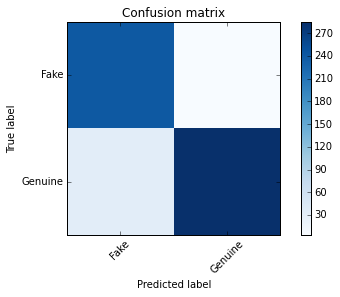

In [13]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[ 0.98367347  0.01632653]
 [ 0.10377358  0.89622642]]


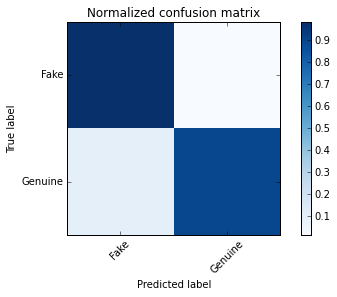

In [14]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [15]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

             precision    recall  f1-score   support

       Fake       0.88      0.98      0.93       245
    Genuine       0.99      0.90      0.94       318

avg / total       0.94      0.93      0.93       563



In [16]:
s=roc_auc_score(y_test, y_pred)
print "roc_auc_score : ",s

roc_auc_score :  0.939949942241


False Positive rate:  [ 0.          0.01632653  1.        ]
True Positive rate:  [ 0.          0.89622642  1.        ]


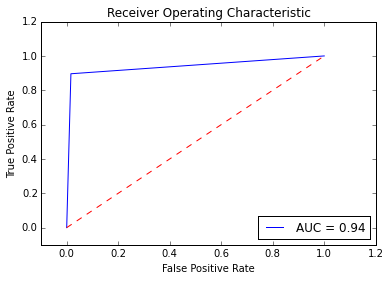

In [17]:
 plot_roc_curve(y_test, y_pred)